# Analiza wyników ankiety dotyczącej wywoływania emocji radości i zaskoczenia w grach wideo

## Przygotowanie danych do analizy

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import pearsonr
from google.colab import drive

In [ ]:
pd.__version__

'2.2.2'

In [ ]:
## pandas version
print(pd.__version__)

## seaborn version
print(sns.__version__)

2.2.2
0.13.2


In [ ]:
sys.version

'3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]'

In [ ]:
# mount drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/badanie_emocji.csv', header=0, sep=',')
df.sample(5)

,Płeć,Wiek,Ile czasu w tygodniu spędzasz grając w gry komputerowe?,"Wybierz, które określenia najbardziej odpowiadają twoim ulubiony gatunkom gier:",Gra 1 - Radość,Gra 1 - Złość,Gra 1 - Smutek,Gra 1 - Obrzydenie,Gra 1 - Zaskoczenie,Gra 1 - Strach,...,"Gra 2 (GEQ) - Uważam, że to strata czasu",Gra 2 (GEQ) - Poczułem/łam się pobudzony,Gra 2 (GEQ) - Czułem/łam się usatysfakcjonowany/na,Gra 2 (GEQ) - Poczułem/łam się zdezorientowany,Gra 2 (GEQ) - Czułem/łam się potężny,Gra 2 (GEQ) - Czułem/łam się zmęczony,Gra 2 (GEQ) - Poczułem/łam żal,Gra 2 (GEQ) - Było mi wstyd,Gra 2 (GEQ) - Czułem/łam się dumny,"Gra 2 (GEQ) - Miałem/łam wrażenie, że wróciłem z podróży"
2,Kobieta,23,2 - 8 godzin w tygodniu,"RPG,FPS,MMO,Puzzle",5,3,2,1,4,3,...,Wcale,Średnio,Mocno,Średnio,Średnio,Wcale,Wcale,Wcale,Średnio,Wcale
8,Mężczyzna,22,Raczej nie gram w gry komputerowe,RPG,4,2,1,1,4,2,...,Lekko,Lekko,Mocno,Mocno,Wcale,Średnio,Wcale,Lekko,Mocno,Wcale
7,Kobieta,27,2 - 8 godzin w tygodniu,"Akcja,Przygoda,Platformowa,Symulacja,Quiz,Eduk...",5,2,1,1,3,3,...,Wcale,Mocno,Średnio,Lekko,Średnio,Wcale,Lekko,Lekko,Lekko,Wcale
3,Mężczyzna,21,Mniej niż 2 godziny w tygodniu,"RPG,FPS",7,1,1,1,4,1,...,Wcale,Mocno,Mocno,Wcale,Średnio,Wcale,Wcale,Wcale,Wcale,Wcale
18,Mężczyzna,20,2 - 8 godzin w tygodniu,Symulacja,3,3,3,3,3,3,...,Lekko,Średnio,Wcale,Średnio,Wcale,Wcale,Lekko,Lekko,Średnio,Wcale


In [ ]:
### Pandas MultiIndex table transformation
metryki_cn = [x.rstrip(': ') for x in df.columns[0:4]]
g1_emotions_cn = [x.rstrip().split(" ")[-1] for x in df.columns[4:10]]
g1_geq_cn = [x.rstrip().split("-")[-1].lstrip() for x in df.columns[10:25]]
g2_emotions_cn = [x.rstrip().split(" ")[-1] for x in df.columns[25:31]]
g2_geq_cn = [x.rstrip().split("-")[-1].lstrip() for x in df.columns[31:46]]

### Correct spelling
g1_emotions_cn[3] = 'Obrzydzenie'
g2_emotions_cn[3] = 'Obrzydzenie'

### Create subtables with multi-index
metryki = df[df.columns[0:4]]
metryki.columns = pd.MultiIndex.from_arrays([['Metryki' for _ in range(4)], metryki_cn])

g1_emotions = df[df.columns[4:10]]
g1_emotions.columns = pd.MultiIndex.from_arrays([['SnappyJump - emocje' for _ in range(6)], g1_emotions_cn])

g1_geq = df[df.columns[10:25]]
g1_geq.columns = pd.MultiIndex.from_arrays([['SnappyJump - GEQ' for _ in range(15)], g1_geq_cn])

g2_emotions = df[df.columns[25:31]]
g2_emotions.columns = pd.MultiIndex.from_arrays([['QuizzMe - emocje' for _ in range(6)], g2_emotions_cn])

g2_geq = df[df.columns[31:46]]
g2_geq.columns = pd.MultiIndex.from_arrays([['QuizzMe - GEQ' for _ in range(15)], g2_geq_cn])

### Create main table from subtables
df = pd.concat([metryki, g1_emotions, g1_geq, g2_emotions, g2_geq], axis=1)
df.head()


Metryki                                                               \
        Płeć Wiek Ile czasu w tygodniu spędzasz grając w gry komputerowe?   
0  Mężczyzna   22                  Raczej nie gram w gry komputerowe        
1    Kobieta   23                            2 - 8 godzin w tygodniu        
2    Kobieta   23                            2 - 8 godzin w tygodniu        
3  Mężczyzna   21                     Mniej niż 2 godziny w tygodniu        
4    Kobieta   26                  Raczej nie gram w gry komputerowe        

                                                                                  \
  Wybierz, które określenia najbardziej odpowiadają twoim ulubiony gatunkom gier   
0                                                RPG                               
1        Akcja,Przygoda,Platformowa,Symulacja,Puzzle                               
2                                 RPG,FPS,MMO,Puzzle                               
3                                            RPG,FPS                               
4                                Przygoda,Edukacyjne                               

  SnappyJump - emocje                                              ...  \
               Radość Złość Smutek Obrzydzenie Zaskoczenie Strach  ...   
0                   2     2      2           2           2      2  ...   
1                   6     3      1           1           5      1  ...   
2                   5     3      2           1           4      3  ...   
3                   7     1      1           1           4      1  ...   
4                   2     2      2           1           1      3  ...   

               QuizzMe - GEQ                             \
  Uważam, że to strata czasu Poczułem/łam się pobudzony   
0                      Wcale                      Wcale   
1                      Wcale                      Wcale   
2                      Wcale                    Średnio   
3                      Wcale                      Mocno   
4                      Lekko               Ekstremalnie   

                                                                         \
  Czułem/łam się usatysfakcjonowany/na Poczułem/łam się zdezorientowany   
0                                Wcale                            Wcale   
1                                Wcale                            Wcale   
2                                Mocno                          Średnio   
3                                Mocno                            Wcale   
4                                Mocno                          Średnio   

                                                                   \
  Czułem/łam się potężny Czułem/łam się zmęczony Poczułem/łam żal   
0                  Wcale                   Wcale            Wcale   
1                  Wcale                   Wcale            Wcale   
2                Średnio                   Wcale            Wcale   
3                Średnio                   Wcale            Wcale   
4                  Lekko                   Wcale            Wcale   

                                      \
  Było mi wstyd Czułem/łam się dumny   
0         Wcale                Wcale   
1         Mocno                Wcale   
2         Wcale              Średnio   
3         Wcale                Wcale   
4         Wcale              Średnio   

                                              
  Miałem/łam wrażenie, że wróciłem z podróży  
0                                      Wcale  
1                                      Wcale  
2                                      Wcale  
3                                      Wcale  
4                               Ekstremalnie  

[5 rows x 46 columns]

In [ ]:
df.to_csv('badanie_emocji_edited.csv')

## Analiza


In [ ]:
game_titles = ["SnappyJump", "QuizzMe"]

In [ ]:
ratings_map = {
    "Wcale" : 0,
    "Lekko" : 1,
    "Średnio": 2,
    "Mocno": 3,
    "Ekstremalnie": 4
}

positive_experience = [0, 4, 6, 7, 9, 13]
negative_experience = [1, 3, 5, 11, 12]
tiredness = [10]
returning_to_reality = [2, 8, 14]

In [ ]:
summarized_frame = pd.DataFrame(df);

for title in game_titles:
    positive_exp_col = pd.DataFrame([df[title + ' - GEQ'].iloc[:, i].map(ratings_map) for i in positive_experience]).transpose()
    negative_exp_col = pd.DataFrame([df[title + ' - GEQ'].iloc[:, i].map(ratings_map) for i in negative_experience]).transpose()
    tierdness_col = pd.DataFrame([df[title + ' - GEQ'].iloc[:, i].map(ratings_map) for i in tiredness]).transpose()
    reality_comeback_col = pd.DataFrame([df[title + ' - GEQ'].iloc[:, i].map(ratings_map) for i in returning_to_reality]).transpose()

    new_columns = {
        'Pozytywne' : positive_exp_col.mean(axis=1),
        'Negatywne' : negative_exp_col.mean(axis=1),
        'Zmęczenie' : tierdness_col.mean(axis=1),
        'Rzeczywistość' : reality_comeback_col.mean(axis=1)
    }

    oldColumns = df[title + ' - GEQ'].columns.values.tolist()

    for key in new_columns:
        summarized_frame[title + ' - GEQ', key] = new_columns[key]

    summarized_frame = summarized_frame.sort_index(axis=1)
    summarized_frame = summarized_frame.drop([(title + ' - GEQ', i) for i in oldColumns], axis=1)


In [ ]:
summarized_frame.sample(5)

Metryki                  \
   Ile czasu w tygodniu spędzasz grając w gry komputerowe?       Płeć Wiek   
18                            2 - 8 godzin w tygodniu       Mężczyzna   20   
27                  Raczej nie gram w gry komputerowe       Mężczyzna   24   
28                  Raczej nie gram w gry komputerowe       Mężczyzna   31   
9                   Raczej nie gram w gry komputerowe       Mężczyzna   21   
25                     Mniej niż 2 godziny w tygodniu       Mężczyzna   16   

                                                                                   \
   Wybierz, które określenia najbardziej odpowiadają twoim ulubiony gatunkom gier   
18                                          Symulacja                               
27                                 FPS,Akcja,Sportowe                               
28                             RPG,FPS,Akcja,Przygoda                               
9                                                Quiz                               
25                  Akcja,Przygoda,Wyścigowe,Sportowe                               

   QuizzMe - GEQ                                   QuizzMe - emocje         \
       Negatywne Pozytywne Rzeczywistość Zmęczenie      Obrzydzenie Radość   
18           1.0  1.333333      0.666667       0.0                2      2   
27           0.0  1.833333      0.000000       0.0                1      3   
28           0.0  1.666667      0.000000       0.0                1      2   
9            0.6  1.166667      1.000000       0.0                2      4   
25           1.8  1.166667      0.666667       1.0                1      3   

    ... SnappyJump - GEQ                                    \
    ...        Negatywne Pozytywne Rzeczywistość Zmęczenie   
18  ...             2.00  2.000000      2.000000       2.0   
27  ...             0.20  2.333333      0.333333       0.0   
28  ...             0.00  2.000000      0.333333       0.0   
9   ...             0.40  2.000000      0.666667       2.0   
25  ...             0.75  1.000000      1.666667       1.0   

   SnappyJump - emocje                                         
           Obrzydzenie Radość Smutek Strach Zaskoczenie Złość  
18                   3      3      3      3           3     3  
27                   1      5      1      1           4     1  
28                   1      6      1      1           3     1  
9                    1      5      1      1           3     2  
25                   2      4      1      3           6     2  

[5 rows x 24 columns]

# Anova

Utworzenie odpowiedniego DataFrame'u z wartościami potrzebnymi do testu ANOVA

In [ ]:
emocje = ['Radość', 'Złość', 'Smutek', 'Obrzydzenie', 'Zaskoczenie', 'Strach']
newFrame = pd.DataFrame(df)

In [ ]:
# Conduct the repeated measures ANOVA
frame = pd.DataFrame({'Ludzie' : np.repeat([*range(0,30)], len(game_titles)),
                        'Gry' : np.tile(game_titles, 30),
                        'Pozytywne' : [summarized_frame.iloc[i][title + ' - GEQ']['Pozytywne'] for i in range(0,30) for title in game_titles],
                        'Negatywne' : [summarized_frame.iloc[i][title + ' - GEQ']['Negatywne'] for i in range(0,30) for title in game_titles],
                        'Zmęczenie' : [summarized_frame.iloc[i][title + ' - GEQ']['Zmęczenie'] for i in range(0,30) for title in game_titles],
                        'Rzeczywistość' : [summarized_frame.iloc[i][title + ' - GEQ']['Rzeczywistość'] for i in range(0,30) for title in game_titles],
                        })
for emocja in emocje:
  frame[emocja + 'Siła'] = [summarized_frame.iloc[i][title + ' - emocje'][emocja] for i in range(0,30) for title in game_titles]


In [ ]:
frame

,Ludzie,Gry,Pozytywne,Negatywne,Zmęczenie,Rzeczywistość,RadośćSiła,ZłośćSiła,SmutekSiła,ObrzydzenieSiła,ZaskoczenieSiła,StrachSiła
0,0,SnappyJump,0.000000,0.00,0.0,0.000000,2,2,2,2,2,2
1,0,QuizzMe,0.000000,0.00,0.0,0.000000,1,1,1,1,1,1
2,1,SnappyJump,3.000000,0.00,0.0,0.333333,6,3,1,1,5,1
3,1,QuizzMe,0.000000,0.80,0.0,0.000000,3,6,1,1,5,1
4,2,SnappyJump,1.833333,1.00,2.0,1.666667,5,3,2,1,4,3
5,2,QuizzMe,2.166667,0.00,0.0,0.666667,4,4,1,1,2,1
6,3,SnappyJump,2.666667,0.00,0.0,0.000000,7,1,1,1,4,1
7,3,QuizzMe,2.166667,0.00,0.0,0.000000,7,1,1,1,1,1
8,4,SnappyJump,1.166667,1.60,2.0,1.000000,2,2,2,1,1,3
9,4,QuizzMe,2.000000,0.80,0.0,2.666667,5,5,3,2,3,2


## Emocje


In [ ]:
for emocja in emocje:
  print("Anova dla emocji " + emocja)
  print(AnovaRM(data=frame, depvar=emocja+'Siła', subject='Ludzie', within=['Gry']).fit())

Anova dla emocji Radość
              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
Gry  7.1443 1.0000 29.0000 0.0122

Anova dla emocji Złość
              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
Gry  6.1670 1.0000 29.0000 0.0190

Anova dla emocji Smutek
              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
Gry  6.1268 1.0000 29.0000 0.0194

Anova dla emocji Obrzydzenie
              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
Gry  0.2371 1.0000 29.0000 0.6300

Anova dla emocji Zaskoczenie
              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
Gry  0.6453 1.0000 29.0000 0.4283

Anova dla emocji Strach
              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
Gry 19.5259 1.0000 29.0000 0.0001



# Anova dla GEQ

## Pozytywne odczucia

In [ ]:
print(AnovaRM(data=frame, depvar='Pozytywne', subject='Ludzie', within=['Gry']).fit())

              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
Gry  1.4714 1.0000 29.0000 0.2349



## Negatywne odczucia

In [ ]:
print(AnovaRM(data=frame, depvar='Negatywne', subject='Ludzie', within=['Gry']).fit())

              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
Gry  0.0213 1.0000 29.0000 0.8850



## Zmęczenie

In [ ]:
print(AnovaRM(data=frame, depvar='Zmęczenie', subject='Ludzie', within=['Gry']).fit())

              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
Gry  5.2135 1.0000 29.0000 0.0299



## Rzeczywistość

In [ ]:
print(AnovaRM(data=frame, depvar='Rzeczywistość', subject='Ludzie', within=['Gry']).fit())

              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
Gry  0.2972 1.0000 29.0000 0.5898



## Tukey

In [ ]:
for emocja in emocje:
  print("Tukey dla emocji " + emocja)
  print(pairwise_tukeyhsd(endog=frame[emocja+'Siła'],groups=frame['Gry'], alpha=0.05))

Tukey dla emocji Radość
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
  group1        group2     meandiff p-adj  lower   upper  reject
----------------------------------------------------------------
Gra Radość Gra Zaskoczenie  -0.8667 0.025 -1.6207 -0.1126   True
----------------------------------------------------------------
Tukey dla emocji Złość
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
  group1        group2     meandiff p-adj   lower  upper  reject
----------------------------------------------------------------
Gra Radość Gra Zaskoczenie   0.7333 0.0553 -0.0173 1.4839  False
----------------------------------------------------------------
Tukey dla emocji Smutek
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1        group2     meandiff p-adj  lower  upper  reject
---------------------------------------------------------------
Gra Radość Gra Zaskoczenie      0.5 0.0299 0.0503 0.9497   True
-----------------------

## Pozytywne odczucia

In [ ]:
print(pairwise_tukeyhsd(endog=frame['Pozytywne'],groups=frame['Gry'], alpha=0.05))

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
  group1        group2     meandiff p-adj   lower  upper  reject
----------------------------------------------------------------
Gra Radość Gra Zaskoczenie  -0.2056 0.2455 -0.5563 0.1451  False
----------------------------------------------------------------


## Negatywne odczucia

In [ ]:
print(pairwise_tukeyhsd(endog=frame['Negatywne'],groups=frame['Gry'], alpha=0.05))

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
  group1        group2     meandiff p-adj   lower  upper  reject
----------------------------------------------------------------
Gra Radość Gra Zaskoczenie  -0.0183 0.9037 -0.3203 0.2836  False
----------------------------------------------------------------


## Rzeczywistość

In [ ]:
print(pairwise_tukeyhsd(endog=frame['Rzeczywistość'],groups=frame['Gry'], alpha=0.05))

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
  group1        group2     meandiff p-adj   lower  upper  reject
----------------------------------------------------------------
Gra Radość Gra Zaskoczenie   0.0778 0.6474 -0.2608 0.4164  False
----------------------------------------------------------------


## Korelacja

Definicja funkcji tworzącej odpowiedni DataFrame do obliczania korelacji dla danej gry

In [ ]:
def getCorelationForGame(gameName: str):
  emocje = ['Radość', 'Złość', 'Smutek', 'Obrzydzenie', 'Zaskoczenie', 'Strach']
  wartosci = ['Pozytywne', 'Negatywne', 'Zmęczenie', 'Rzeczywistość']
  corel = pd.DataFrame()

  for geq in wartosci:
    corel[geq] = summarized_frame[gameName + " - GEQ"][geq]
  for emocja in emocje:
    corel[emocja] = summarized_frame[gameName + " - emocje"][emocja]

  corel.head()
  return corel;


### Gra Radość x GEQ

In [ ]:
corel = getCorelationForGame("SnappyJump")
corel

,Pozytywne,Negatywne,Zmęczenie,Rzeczywistość,Radość,Złość,Smutek,Obrzydzenie,Zaskoczenie,Strach
0,0.000000,0.00,0.0,0.000000,2,2,2,2,2,2
1,3.000000,0.00,0.0,0.333333,6,3,1,1,5,1
2,1.833333,1.00,2.0,1.666667,5,3,2,1,4,3
3,2.666667,0.00,0.0,0.000000,7,1,1,1,4,1
4,1.166667,1.60,2.0,1.000000,2,2,2,1,1,3
5,2.000000,0.00,0.0,0.000000,4,6,1,1,2,1
6,0.500000,0.40,0.0,0.000000,3,1,1,1,1,1
7,3.000000,0.00,0.0,0.333333,5,2,1,1,3,3
8,2.000000,0.40,0.0,0.333333,4,2,1,1,4,2
9,2.000000,0.40,2.0,0.666667,5,2,1,1,3,1


In [ ]:
rho = corel.corr()
pval = corel.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.map(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
rho.round(2).astype(str) + p

,Pozytywne,Negatywne,Zmęczenie,Rzeczywistość,Radość,Złość,Smutek,Obrzydzenie,Zaskoczenie,Strach
Pozytywne,1.0***,-0.12,-0.02,0.14,0.44**,0.1,-0.1,0.03,0.25,-0.01
Negatywne,-0.12,1.0***,0.49***,0.65***,-0.36*,-0.16,0.37**,0.42**,-0.01,0.31*
Zmęczenie,-0.02,0.49***,1.0***,0.21,-0.01,-0.17,0.33*,0.19,0.45**,0.45**
Rzeczywistość,0.14,0.65***,0.21,1.0***,-0.29,-0.09,0.37**,0.31*,-0.08,0.18
Radość,0.44**,-0.36*,-0.01,-0.29,1.0***,-0.01,-0.36**,-0.24,0.44**,0.07
Złość,0.1,-0.16,-0.17,-0.09,-0.01,1.0***,0.26,0.08,-0.1,-0.09
Smutek,-0.1,0.37**,0.33*,0.37**,-0.36**,0.26,1.0***,0.25,-0.02,0.27
Obrzydzenie,0.03,0.42**,0.19,0.31*,-0.24,0.08,0.25,1.0***,0.2,0.3
Zaskoczenie,0.25,-0.01,0.45**,-0.08,0.44**,-0.1,-0.02,0.2,1.0***,0.4**
Strach,-0.01,0.31*,0.45**,0.18,0.07,-0.09,0.27,0.3,0.4**,1.0***


### Gra Zaskoczenie x GEQ

In [ ]:
corel = getCorelationForGame("QuizzMe")
corel.head()

,Pozytywne,Negatywne,Zmęczenie,Rzeczywistość,Radość,Złość,Smutek,Obrzydzenie,Zaskoczenie,Strach
0,0.000000,0.0,0.0,0.000000,1,1,1,1,1,1
1,0.000000,0.8,0.0,0.000000,3,6,1,1,5,1
2,2.166667,0.0,0.0,0.666667,4,4,1,1,2,1
3,2.166667,0.0,0.0,0.000000,7,1,1,1,1,1
4,2.000000,0.8,0.0,2.666667,5,5,3,2,3,2


In [ ]:
rho = corel.corr()
pval = corel.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
rho.round(2).astype(str) + p

<ipython-input-71-44d207418e77>:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))


,Pozytywne,Negatywne,Zmęczenie,Rzeczywistość,Radość,Złość,Smutek,Obrzydzenie,Zaskoczenie,Strach
Pozytywne,1.0***,-0.02,-0.06,0.17,0.34*,-0.17,-0.01,-0.14,-0.11,-0.01
Negatywne,-0.02,1.0***,0.39**,0.51***,-0.14,0.19,0.39**,0.13,0.39**,0.19
Zmęczenie,-0.06,0.39**,1.0***,0.28,-0.05,0.12,0.26,-0.11,0.19,-0.15
Rzeczywistość,0.17,0.51***,0.28,1.0***,-0.02,0.14,0.34*,0.25,0.26,0.22
Radość,0.34*,-0.14,-0.05,-0.02,1.0***,-0.22,0.25,-0.2,-0.3,-0.14
Złość,-0.17,0.19,0.12,0.14,-0.22,1.0***,-0.0,0.12,0.15,0.18
Smutek,-0.01,0.39**,0.26,0.34*,0.25,-0.0,1.0***,0.31*,-0.08,0.31*
Obrzydzenie,-0.14,0.13,-0.11,0.25,-0.2,0.12,0.31*,1.0***,0.06,0.12
Zaskoczenie,-0.11,0.39**,0.19,0.26,-0.3,0.15,-0.08,0.06,1.0***,-0.01
Strach,-0.01,0.19,-0.15,0.22,-0.14,0.18,0.31*,0.12,-0.01,1.0***


## Wykresy

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
print(matplotlib.__version__)

3.10.0


In [ ]:
emocje = ['Radość', 'Złość', 'Smutek', 'Obrzydzenie', 'Zaskoczenie', 'Strach']
labels = ['SnappyJump', 'QuizzMe']

In [ ]:
geq = ['Pozytywne', 'Negatywne', 'Zmęczenie', 'Rzeczywistość']

In [ ]:
game_time_map = {
    'Raczej nie gram w gry komputerowe': 0,
    'Mniej niż 2 godziny w tygodniu': 1,
    '2 - 8 godzin w tygodniu': 2,
    'Więcej niż 8 godzin w tygodniu': 3
}

In [ ]:
## Create new Seaborn color palette with 5 colors, which I can define
colors = ['#607196', '#d0e3c4', '#ff7b9c', '#DDB967', '#00171f', '#ffffff']
my_pal = sns.color_palette(colors)


<ipython-input-73-375d35d1e58a>:25: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.barplot(emotions_mean_df, x='Emocja', y='Średnia Wartość', hue='Gra', palette=my_pal)


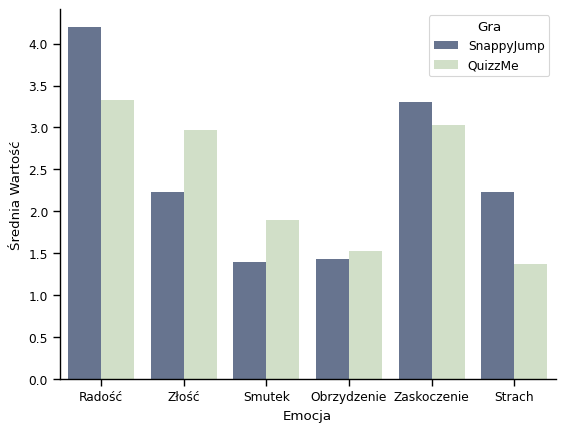

In [ ]:
import numpy as np

g1_emotions_mean = [df['SnappyJump - emocje'][emocja].mean() for emocja in emocje]
g2_emotions_mean = [df['QuizzMe - emocje'][emocja].mean() for emocja in emocje]

for i in range(0,6):
  g1_emotions_mean[i] = round(g1_emotions_mean[i], 2)
  g2_emotions_mean[i] = round(g2_emotions_mean[i], 2)

mean_emotions = np.concatenate((g1_emotions_mean, g2_emotions_mean))

columns = ['Emocja', 'Średnia Wartość', 'Gra']

emotions_mean_df = pd.DataFrame(columns=columns)

for gi, gt in enumerate(game_titles):
    for index, em in enumerate(emocje):
        new_index = index + (gi * 6)
        new_row = [em, mean_emotions[new_index], gt]
        emotions_mean_df.loc[new_index] = new_row

emotions_mean_df

sns.set_context("paper")
sns.barplot(emotions_mean_df, x='Emocja', y='Średnia Wartość', hue='Gra', palette=my_pal)
sns.despine()

In [ ]:
g1_emotions_mean

[4.2, 2.23, 1.4, 1.43, 3.3, 2.23]

<ipython-input-76-3b930694eba8>:19: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.barplot(geq_mean_df, x='Czynniki GEQ', y='Średnia Wartość', hue='Gra', palette=my_pal)


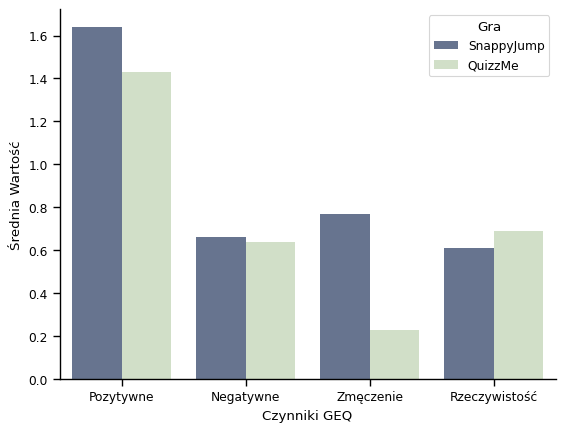

In [ ]:
g1_geq_mean = frame[frame['Gry'] == 'SnappyJump'][['Pozytywne', 'Negatywne', 'Zmęczenie', 'Rzeczywistość', 'Gry']]
g2_geq_mean = frame[frame['Gry'] == 'QuizzMe'][['Pozytywne', 'Negatywne', 'Zmęczenie', 'Rzeczywistość', 'Gry']]

columns = ['Czynniki GEQ', 'Średnia Wartość', 'Gra']

geq_mean_df = pd.DataFrame(columns=columns)

for col in g1_geq_mean.columns:
  if col != 'Gry':
    new_row = [col, round(g1_geq_mean[col].mean(), 2), 'SnappyJump']
    geq_mean_df.loc[len(geq_mean_df)] = new_row

for col in g2_geq_mean.columns:
  if col != 'Gry':
    new_row = [col, round(g2_geq_mean[col].mean(), 2), 'QuizzMe']
    geq_mean_df.loc[len(geq_mean_df)] = new_row

sns.set_context("paper")
sns.barplot(geq_mean_df, x='Czynniki GEQ', y='Średnia Wartość', hue='Gra', palette=my_pal)
sns.despine()

# geq_mean_df = pd.DataFrame(columns=columns)

In [ ]:
frame.sample(5)

,Ludzie,Gry,Pozytywne,Negatywne,Zmęczenie,Rzeczywistość,RadośćSiła,ZłośćSiła,SmutekSiła,ObrzydzenieSiła,ZaskoczenieSiła,StrachSiła
0,0,Gra Radość,0.000000,0.0,0.0,0.000000,2,2,2,2,2,2
40,20,Gra Radość,0.833333,0.4,0.0,0.000000,3,4,2,2,4,1
39,19,Gra Zaskoczenie,1.833333,1.2,0.0,0.000000,3,5,4,2,2,1
12,6,Gra Radość,0.500000,0.4,0.0,0.000000,3,1,1,1,1,1
31,15,Gra Zaskoczenie,1.166667,1.2,0.0,0.666667,4,2,3,2,2,1


<ipython-input-77-72cad21198fb>:18: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax = sns.violinplot(data=data_long, x='Intensywność', y='Emocja', hue='Gry', palette=my_pal, split=True, gap=.1, inner='quart')


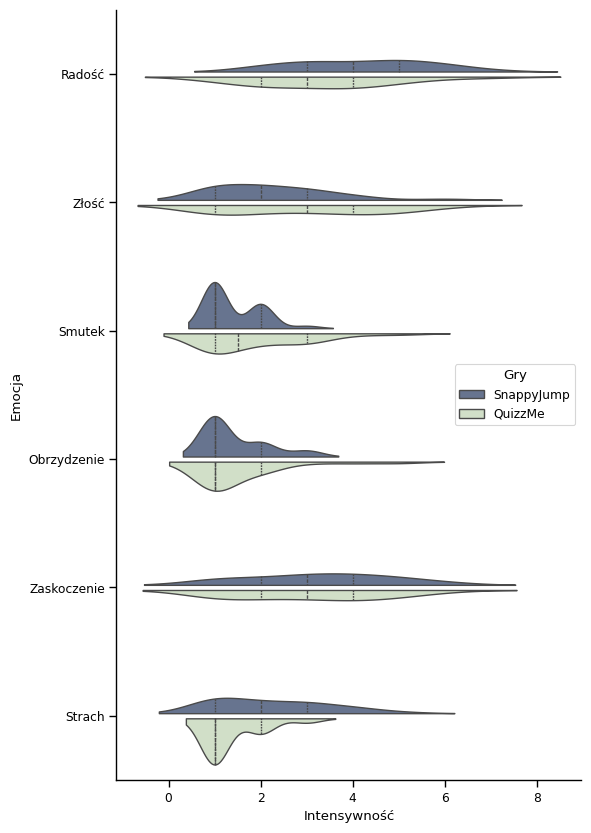

In [ ]:
data = frame[['RadośćSiła',
                           'ZłośćSiła',
                           'SmutekSiła',
                           'ObrzydzenieSiła',
                           'ZaskoczenieSiła',
                           'StrachSiła',
                           'Gry']]

data_long = data.melt(id_vars='Gry',
                      value_vars=['RadośćSiła', 'ZłośćSiła', 'SmutekSiła', 'ObrzydzenieSiła', 'ZaskoczenieSiła', 'StrachSiła'],
                      var_name='Emocja',
                      value_name='Intensywność')

data_long['Emocja'] = data_long['Emocja'].str.split('Siła').str[0]

sns.set_context("paper")
plt.figure(figsize=(6, 10))
ax = sns.violinplot(data=data_long, x='Intensywność', y='Emocja', hue='Gry', palette=my_pal, split=True, gap=.1, inner='quart')
sns.move_legend(ax, "center right")
sns.despine()

<ipython-input-78-bf82a701f4cb>:10: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  bx = sns.violinplot(data=data2_long, x='Intensywność', y='Czynniki GEQ', hue='Gry', palette=my_pal, split=True, gap=.1, inner='quart')


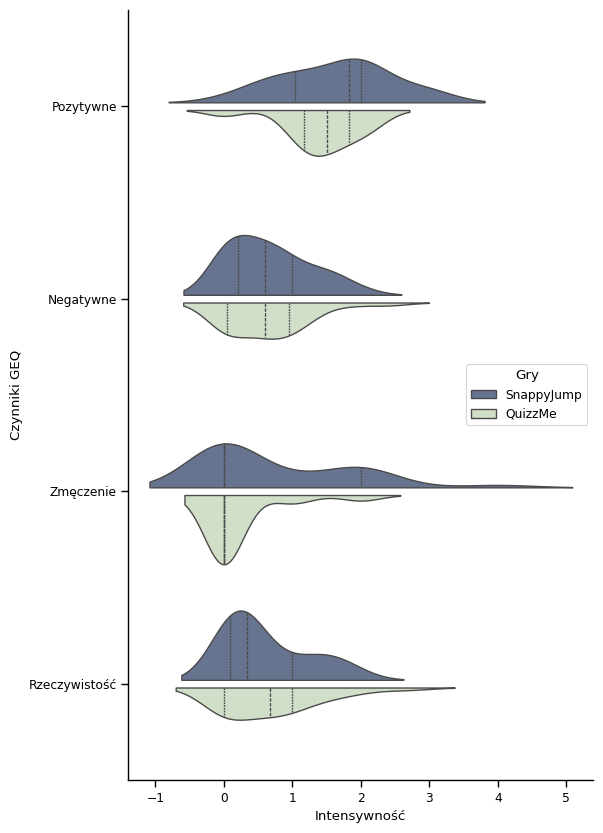

In [ ]:
data2 = frame[['Pozytywne', 'Negatywne', 'Zmęczenie', 'Rzeczywistość', 'Gry']]

data2_long = data2.melt(id_vars='Gry',
                        value_vars=['Pozytywne', 'Negatywne', 'Zmęczenie', 'Rzeczywistość'],
                      var_name='Czynniki GEQ',
                      value_name='Intensywność')

sns.set_context("paper")
plt.figure(figsize=(6, 10))
bx = sns.violinplot(data=data2_long, x='Intensywność', y='Czynniki GEQ', hue='Gry', palette=my_pal, split=True, gap=.1, inner='quart')
sns.move_legend(bx, "center right")
sns.despine()

In [ ]:
df

Metryki                                                               \
         Płeć Wiek Ile czasu w tygodniu spędzasz grając w gry komputerowe?   
0   Mężczyzna   22                  Raczej nie gram w gry komputerowe        
1     Kobieta   23                            2 - 8 godzin w tygodniu        
2     Kobieta   23                            2 - 8 godzin w tygodniu        
3   Mężczyzna   21                     Mniej niż 2 godziny w tygodniu        
4     Kobieta   26                  Raczej nie gram w gry komputerowe        
5     Kobieta   26                     Mniej niż 2 godziny w tygodniu        
6   Mężczyzna   26                  Raczej nie gram w gry komputerowe        
7     Kobieta   27                            2 - 8 godzin w tygodniu        
8   Mężczyzna   22                  Raczej nie gram w gry komputerowe        
9   Mężczyzna   21                  Raczej nie gram w gry komputerowe        
10    Kobieta   23                     Mniej niż 2 godziny w tygodniu        
11    Kobieta   23                            2 - 8 godzin w tygodniu        
12    Kobieta   23                            2 - 8 godzin w tygodniu        
13    Kobieta   24                            2 - 8 godzin w tygodniu        
14  Mężczyzna   21                     Mniej niż 2 godziny w tygodniu        
15  Mężczyzna   32                  Raczej nie gram w gry komputerowe        
16  Mężczyzna   21                     Więcej niż 8 godzin w tygodniu        
17  Mężczyzna   21                     Mniej niż 2 godziny w tygodniu        
18  Mężczyzna   20                            2 - 8 godzin w tygodniu        
19  Mężczyzna   21                     Mniej niż 2 godziny w tygodniu        
20  Mężczyzna   20                  Raczej nie gram w gry komputerowe        
21    Kobieta   47                  Raczej nie gram w gry komputerowe        
22  Mężczyzna   37                     Mniej niż 2 godziny w tygodniu        
23  Mężczyzna   33                            2 - 8 godzin w tygodniu        
24  Mężczyzna   17                     Więcej niż 8 godzin w tygodniu        
25  Mężczyzna   16                     Mniej niż 2 godziny w tygodniu        
26  Mężczyzna   23                  Raczej nie gram w gry komputerowe        
27  Mężczyzna   24                  Raczej nie gram w gry komputerowe        
28  Mężczyzna   31                  Raczej nie gram w gry komputerowe        
29    Kobieta   23                            2 - 8 godzin w tygodniu        

                                                                                   \
   Wybierz, które określenia najbardziej odpowiadają twoim ulubiony gatunkom gier   
0                                                 RPG                               
1         Akcja,Przygoda,Platformowa,Symulacja,Puzzle                               
2                                  RPG,FPS,MMO,Puzzle                               
3                                             RPG,FPS                               
4                                 Przygoda,Edukacyjne                               
5                                 Akcja,Przygoda,Quiz                               
6                                  FPS,Akcja,Przygoda                               
7   Akcja,Przygoda,Platformowa,Symulacja,Quiz,Eduk...                               
8                                                 RPG                               
9                                                Quiz                               
10                                 Przygoda,Symulacja                               
11                                    RPG,Platformowa                               
12                      RPG,Przygoda,Symulacja,Puzzle                               
13                                         FPS,Puzzle                               
14                                            RPG,FPS                               
15                                                RPG           

<ipython-input-51-722103071435>:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.displot(age, color=my_pal[0], palette=my_pal, kind='hist')


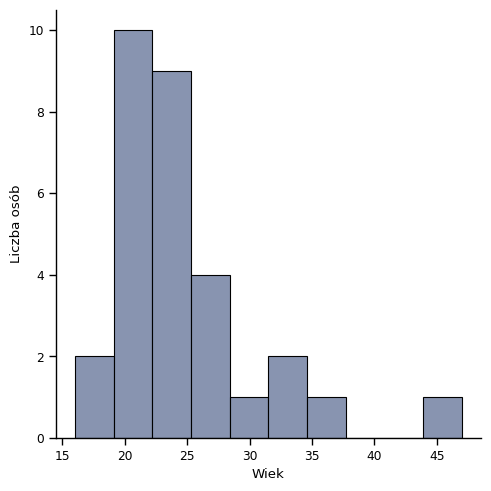

In [ ]:
age = df['Metryki']['Wiek']

sns.set_context("paper")
sns.displot(age, color=my_pal[0], palette=my_pal, kind='hist')
plt.ylabel('Liczba osób')
plt.xlabel('Wiek')
sns.despine()

<ipython-input-52-27edc879cdcf>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(game_time, palette=my_pal[0:2], width=0.5)
<ipython-input-52-27edc879cdcf>:4: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(game_time, palette=my_pal[0:2], width=0.5)


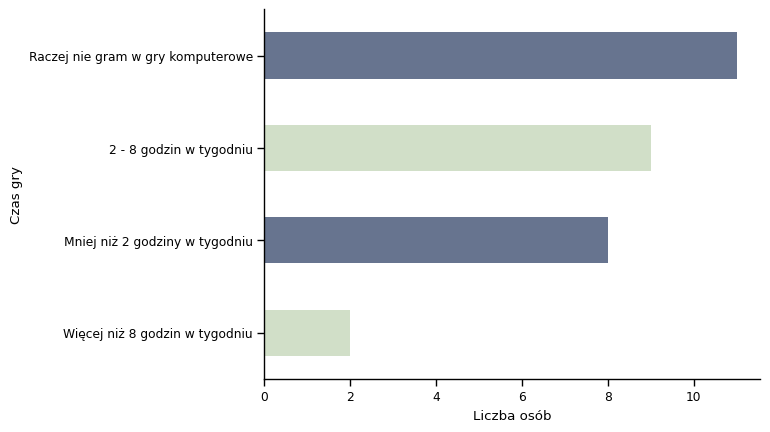

In [ ]:
game_time = df['Metryki']['Ile czasu w tygodniu spędzasz grając w gry komputerowe?']

sns.set_context("paper")
sns.countplot(game_time, palette=my_pal[0:2], width=0.5)
plt.xlabel('Liczba osób')
plt.ylabel('Czas gry')
sns.despine()

<ipython-input-79-d657b1f40121>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(fv_game_types, palette=my_pal[0:1], width=0.5)
<ipython-input-79-d657b1f40121>:14: UserWarning: 
The palette list has fewer values (1) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(fv_game_types, palette=my_pal[0:1], width=0.5)


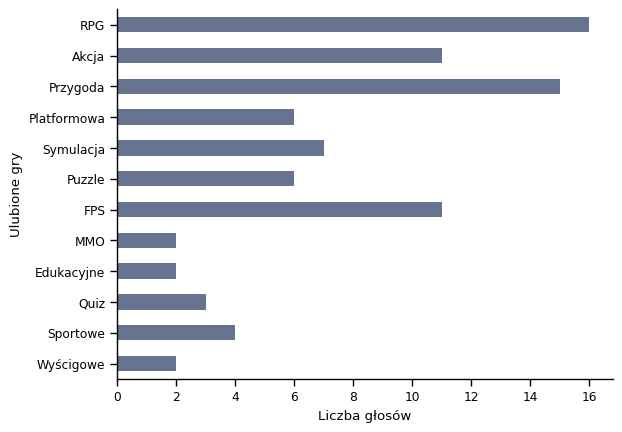

In [ ]:
fv_game_types = df['Metryki']['Wybierz, które określenia najbardziej odpowiadają twoim ulubiony gatunkom gier']

# fv_game_types = fv_game_types.str.split(',')
games = []

for _ in list(fv_game_types):
    temp = _.split(',')
    for game in temp:
        games.append(game.strip())

fv_game_types = pd.Series(games)

sns.set_context("paper")
sns.countplot(fv_game_types, palette=my_pal[0:1], width=0.5)
plt.xlabel('Liczba głosów')
plt.ylabel('Ulubione gry')
sns.despine()
